# WeatherData Notebook

### Collects weather and climate data from NOAA NCDC using a REST API

Modified version of the notebook used to pull data for San Diego as well as NYC

In [0]:
import urllib.request
import urllib.error
import json

import pandas as pd

import matplotlib.pyplot as plt

In [0]:
 # NOAA requires a unique assigned token in the header
header = {
    'Token': 'zrnlkpVzUHrqOgbNDUzoHQzZDUcJvsKM'
}

In [0]:
# starting year
year = 2000

# list of results
nyc_results_list = []
sd_results_list = []

# NYC weather station is located at La Guardia Airport, GHCND:USW00014732
# San Diego weather station is located at San Diego International Airport, GHCND:USW00023188

# NOAA allows a maximum query return size of 1000 records (temp/precip/snow, etc), roughly 1 year
# Loop to make multiple requests
while year <= 2018:
        noaa_nyc_url_1h = f'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&' \
        f'stationid=GHCND:USW00014732&startdate={year}-01-01&enddate={year}-06-30&' \
        f'limit=1000&datatypeid=TMAX,TMIN,SNOW,PRCP'
        
        noaa_nyc_url_2h = f'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&' \
        f'stationid=GHCND:USW00014732&startdate={year}-07-01&enddate={year}-12-31&' \
        f'limit=1000&datatypeid=TMAX,TMIN,SNOW,PRCP'
        
        noaa_sd_url_1h = f'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&' \
        f'stationid=GHCND:USW00023188&startdate={year}-01-01&enddate={year}-06-30&' \
        f'limit=1000&datatypeid=TMAX,TMIN,SNOW,PRCP'
        
        noaa_sd_url_2h = f'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&' \
        f'stationid=GHCND:USW00023188&startdate={year}-07-01&enddate={year}-12-31&' \
        f'limit=1000&datatypeid=TMAX,TMIN,SNOW,PRCP'
        
        # Build HTTP requests
        nyc_req_1h = urllib.request.Request(noaa_nyc_url_1h, headers=header)
        nyc_req_2h = urllib.request.Request(noaa_nyc_url_2h, headers=header)
        sd_req_1h = urllib.request.Request(noaa_sd_url_1h, headers=header)
        sd_req_2h = urllib.request.Request(noaa_sd_url_2h, headers=header)
        
        # Retrieve
        try:
            nyc_resp_1h = urllib.request.urlopen(nyc_req_1h)
            nyc_resp_2h = urllib.request.urlopen(nyc_req_2h)
            sd_resp_1h = urllib.request.urlopen(sd_req_1h)
            sd_resp_2h = urllib.request.urlopen(sd_req_2h)
        except (urllib.error.HTTPError, urllib.error.URLError) as err:
            print('Unable to connect to NOAA data on the Internet:\n', err)
            break
        
        
        # Parse json data
        nyc_resp_json_1h = json.loads(nyc_resp_1h.read().decode('utf-8'))
        nyc_resp_json_2h = json.loads(nyc_resp_2h.read().decode('utf-8'))
        sd_resp_json_1h = json.loads(sd_resp_1h.read().decode('utf-8'))
        sd_resp_json_2h = json.loads(sd_resp_2h.read().decode('utf-8'))
        
        # Results
        nyc_results_list = nyc_results_list + nyc_resp_json_1h['results']
        nyc_results_list = nyc_results_list + nyc_resp_json_2h['results']
        sd_results_list = sd_results_list + sd_resp_json_1h['results']
        sd_results_list = sd_results_list + sd_resp_json_2h['results']
        
        print('Retrieved year: ', year)
        
        year += 1

Retrieved year:  2000
Retrieved year:  2001
Retrieved year:  2002
Retrieved year:  2003
Retrieved year:  2004
Retrieved year:  2005
Retrieved year:  2006
Retrieved year:  2007
Retrieved year:  2008
Retrieved year:  2009
Retrieved year:  2010
Retrieved year:  2011
Retrieved year:  2012
Retrieved year:  2013
Retrieved year:  2014
Retrieved year:  2015
Retrieved year:  2016
Retrieved year:  2017
Retrieved year:  2018


In [0]:
# Re-pack into dictionary for DF creation
dates = []
precip = []
snow = []
tmax = []
tmin = []

for result in nyc_results_list:
    if result['datatype'] == 'PRCP':
        dates.append(result['date'])
        precip.append(result['value'])
        
    elif result['datatype'] == 'SNOW':
        snow.append(result['value'])
        
    elif result['datatype'] == 'TMAX':
        tmax.append(result['value'])
        
    elif result['datatype'] == 'TMIN':
        tmin.append(result['value'])
        
    else:
        # a value that is not needed
        continue

nyc_weather_dict = { 'Date': dates, 'Precip': precip, 'Snow': snow, 'TMax': tmax, 'TMin': tmin }

dates = []
precip = []
snow = []
tmax = []
tmin = []

# PRCP data type marks the start of a new date
# not all days have snow or min temp data,
# use these variables to keep track
had_snow = True
had_min = True

for result in sd_results_list:
    if result['datatype'] == 'PRCP':
        
        # if the previous observation didn't have snow or 
        # 
        if not had_snow:
            snow.append(None)
            
        if not had_min:
            tmin.append(None)
            
        dates.append(result['date'])
        precip.append(result['value'])
        
        # reset had_snow and had_min
        had_snow = False
        had_min = False
        
    elif result['datatype'] == 'SNOW':
        snow.append(result['value'])
        had_snow = True
        
    elif result['datatype'] == 'TMAX':
        tmax.append(result['value'])
        
    elif result['datatype'] == 'TMIN':
        tmin.append(result['value'])
        had_min = True
        
    else:
        # a value that is not needed
        continue
        
snow.append(None)

sd_weather_dict = { 'Date': dates, 'Precip': precip, 'Snow': snow, 'TMax': tmax, 'TMin': tmin }

In [0]:
print(len(sd_weather_dict['Date']), 
      len(sd_weather_dict['Precip']),
      len(sd_weather_dict['Snow']),
      len(sd_weather_dict['TMax']),
      len(sd_weather_dict['TMin']) )

6940 6940 6940 6940 6940


In [0]:
# Create DFs and examine
nyc_weather_df = pd.DataFrame(nyc_weather_dict)
nyc_weather_df['Date'] = pd.to_datetime( nyc_weather_df['Date'] )
nyc_weather_df.set_index('Date', inplace=True)

sd_weather_df = pd.DataFrame(sd_weather_dict)
sd_weather_df['Date'] = pd.to_datetime( sd_weather_df['Date'] )
sd_weather_df.set_index('Date', inplace=True)

# Convert tenths of degrees to degrees C
nyc_weather_df['TMax'] = nyc_weather_df['TMax'] / 10
nyc_weather_df['TMin'] = nyc_weather_df['TMin'] / 10
sd_weather_df['TMax'] = sd_weather_df['TMax'] / 10
sd_weather_df['TMin'] = sd_weather_df['TMin'] / 10

# Convert tenths of mm to mm
nyc_weather_df['Precip'] = nyc_weather_df['Precip'] / 10
sd_weather_df['Precip'] = sd_weather_df['Precip'] / 10

nyc_weather_df.head()

,Precip,Snow,TMax,TMin
Date,,,,
2000-01-01,0.0,0,10.0,1.7
2000-01-02,0.0,0,15.6,5.0
2000-01-03,0.0,0,17.2,8.3
2000-01-04,18.0,0,15.0,7.2
2000-01-05,0.0,0,8.9,-1.1


In [0]:
sd_weather_df.head()

,Precip,Snow,TMax,TMin
Date,,,,
2000-01-01,0.8,0.0,15.0,10.6
2000-01-02,0.0,0.0,15.6,9.4
2000-01-03,0.0,0.0,19.4,7.2
2000-01-04,0.0,0.0,19.4,7.2
2000-01-05,0.0,0.0,17.8,7.2


In [0]:
# Write the DFs out to CSV
nyc_weather_df.to_csv('nyc_weather.csv')
sd_weather_df.to_csv('sd_weather.csv')

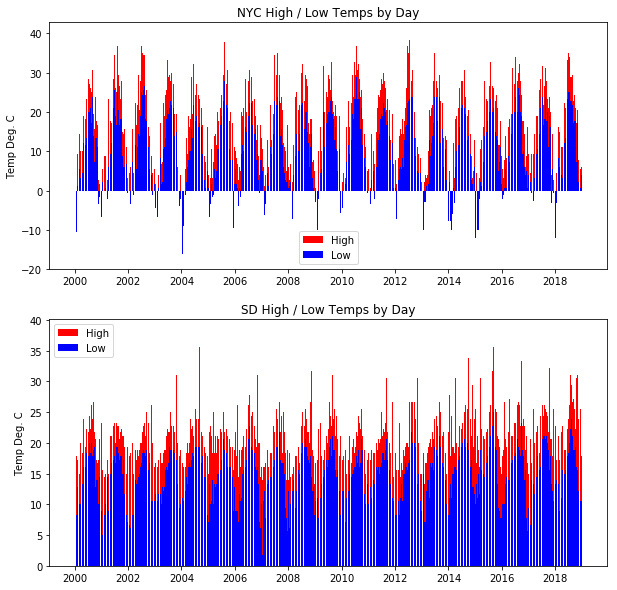

In [0]:
# Plot temperatures
plt.figure( figsize = (10,10) )

plt.subplot(2, 1, 1)
pmax = plt.bar(nyc_weather_df.index, nyc_weather_df['TMax'], color='red')
pmin = plt.bar(nyc_weather_df.index, nyc_weather_df['TMin'], color='blue')

plt.ylabel('Temp Deg. C')
plt.title('NYC High / Low Temps by Day')
plt.legend((pmax[0], pmin[0]), ('High', 'Low'))

plt.subplot(2, 1, 2)
pmax = plt.bar(sd_weather_df.index, sd_weather_df['TMax'], color='red')
pmin = plt.bar(sd_weather_df.index, sd_weather_df['TMin'], color='blue')

plt.ylabel('Temp Deg. C')
plt.title('SD High / Low Temps by Day')
plt.legend((pmax[0], pmin[0]), ('High', 'Low'))

plt.show()

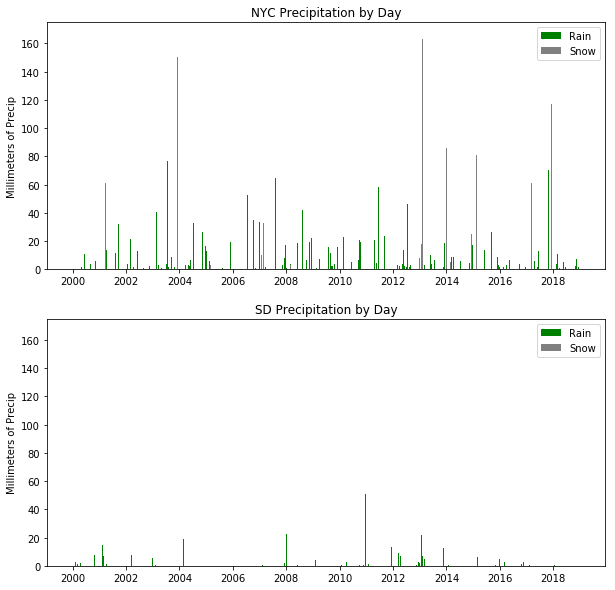

In [0]:
# Plot precipitation
plt.figure( figsize = (10,10) )

ax1 = plt.subplot(2, 1, 1)
p_rain = ax1.bar(nyc_weather_df.index, nyc_weather_df['Precip'], color='green')
p_snow = ax1.bar(nyc_weather_df.index, nyc_weather_df['Snow'], color='gray')

ax1.set_ylabel('Millimeters of Precip')
ax1.set_title('NYC Precipitation by Day')
ax1.set_ylim(bottom=0, top=175)
ax1.legend((p_rain[0], p_snow[0]), ('Rain', 'Snow'))

ax2 = plt.subplot(2, 1, 2)
p_rain = ax2.bar(sd_weather_df.index, sd_weather_df['Precip'], color='green')
p_snow = ax2.bar(sd_weather_df.index, sd_weather_df['Snow'], color='gray')

ax2.set_ylim(bottom=0, top=175)
ax2.set_ylabel('Millimeters of Precip')
ax2.set_title('SD Precipitation by Day')
ax2.legend((p_rain[0], p_snow[0]), ('Rain', 'Snow'))

plt.show()

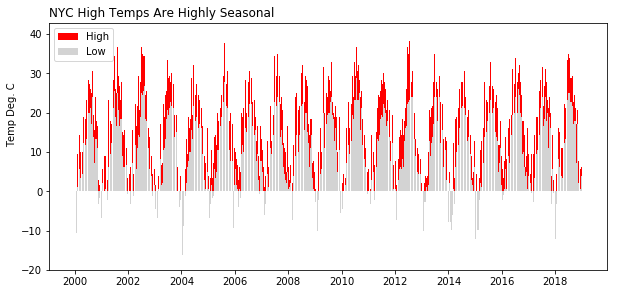

In [0]:
# Cat in the hat!

# Plot temperatures
plt.figure( figsize = (10,10) )

plt.subplot(2, 1, 1)
pmax = plt.bar(nyc_weather_df.index, nyc_weather_df['TMax'], color='red')
pmin = plt.bar(nyc_weather_df.index, nyc_weather_df['TMin'], color='lightgray')

plt.ylabel('Temp Deg. C', horizontalalignment='left')
plt.title('NYC High Temps Are Highly Seasonal', loc='left')
plt.legend((pmax[0], pmin[0]), ('High', 'Low'), loc='upper left')

plt.show()

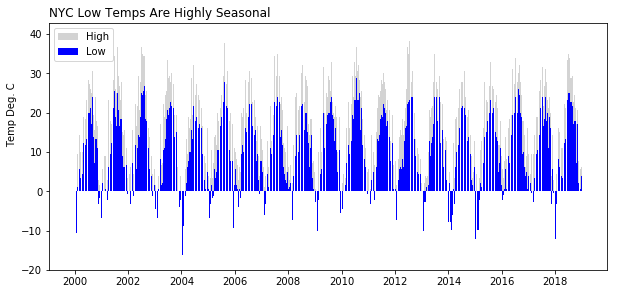

In [0]:
# Cat in the hat!

# Plot temperatures
plt.figure( figsize = (10,10) )

plt.subplot(2, 1, 1)
pmax = plt.bar(nyc_weather_df.index, nyc_weather_df['TMax'], color='lightgray')
pmin = plt.bar(nyc_weather_df.index, nyc_weather_df['TMin'], color='blue')

plt.ylabel('Temp Deg. C', horizontalalignment='left')
plt.title('NYC Low Temps Are Highly Seasonal', loc='left')
plt.legend((pmax[0], pmin[0]), ('High', 'Low'), loc='upper left')

plt.show()